# Lab 01: ISS data loading

## 0) Preparing the raw data

To tell the story from the begginning and make this lab as close to practice as possible, we will start with the raw data. Depending on the microscope and imaging software, one would get the data in different formats. In this case, we had a CZI image which was then transofrmed into individual tiles using the [Zeiss ZEN Blue](https://www.zeiss.com/microscopy/int/products/microscope-software/zen-lite.html) free software. 

This resulted in $(rounds \times channels \times tiles \times Zstack)$ images of $(2048 \times 2048)$ pixels, where: <br>
$rounds = 4$ <br>
$channels = 5$; in order, DAPI for the nuclei + 4 primary stains (Cy3, Cy5, Cy7, FITC)   <br>
$tiles = 34$ <br>
$Zstack = 21$

The naming in the experiments is also very variable, so preparing the data by homogeneizing it is usually a good practice. In this case, we will prepare the data to be loaded in the [SpaceTX format](https://spacetx-starfish.readthedocs.io/en/latest/gallery/data_formatting/plot_format_structured_data.html#sphx-glr-gallery-data-formatting-plot-format-structured-data-py). We previously created the helper functions to convert the data into the format. 

We do not need to load the whole experiment to showcase the different parts of what makes a ISS workflow so only a subset of tiles and rounds will be loaded. Specifically, 9 patches from two rounds are selected.

In [1]:
import sys
import os

from iss_utils import read_starfish
import numpy as np

First, we will create symbolic links to the original files, to avoid changing the file names. 

In [2]:
base_dir = '../data/in_situ_sequencing/raw'
out_dir = '../data/in_situ_sequencing/SpaceTX_subsample'

os.makedirs(out_dir, exist_ok=True)

n_rounds = 2 # selected subset of rounds (0 and 1)
n_channels = 5
n_zplanes = 21 
#fov_names = [9,10,11,
#             16,17,18,
#             23,24,25] # selected subset of the tiles
fov_names = [16,17,
             23,24] # selected subset of the tiles


(primary_dir, nuclei_dir) = read_starfish.format_data(base_dir=base_dir,
                                                      out_dir=out_dir,
                                                      n_rounds=n_rounds, 
                                                      n_channels=n_channels,
                                                      n_zplanes=n_zplanes,
                                                      fov_names=fov_names,
                                                      dapi_channel=0, # DAPI channels is the first one
                                                      file_format=r'Round{r}/Round{r}_z{z+1:02d}c{ch+1}m{fov:02d}_ORG.tif')

Next, we create the coordinate CSV for the images. Notice that here we manually defined the resolution, coordinates, etc. but this can be directly parsed from the experiment metadata. 

In [ ]:
xyz_res = [0.325, 0.325, 0.5] # micrometers per pixel

fov_coordinates = { 9:[3887, 1847, 0], 10:[5530, 1847, 0], 11:[7373, 1847, 0], 
                   16:[3887, 3692, 0], 17:[5530, 3692, 0], 18:[7373, 3692, 0], 
                   23:[3887, 5535, 0], 24:[5530, 5535, 0], 25:[7373, 5535, 0]} # coordinates in pixels

fov_coordinates = [fov_coordinates[tile] for tile in fov_names]
                   
fov_coordinates = np.array(fov_coordinates)*xyz_res # coordinates in micrometers

xy_max = 2048*xyz_res[0] # max XY size of a tile in micrometers
z_max = xyz_res[2] # max Z size of a tile in micrometers

(primary_df, nuclei_df)= read_starfish.create_coordinates(primary_dir=primary_dir,
                                                          nuclei_dir=nuclei_dir,
                                                          n_rounds=n_rounds,
                                                          n_channels=n_channels,
                                                          n_zplanes=n_zplanes,
                                                          fov_names=fov_names,
                                                          xy_max = xy_max,
                                                          z_max = z_max,
                                                          fov_coordinates=fov_coordinates)

Finally, we are ready to generate the **SpaceTX** formatted data to load in starfish.

In [4]:
read_starfish.space_tx(output_dir=out_dir,
                       primary_dir=primary_dir,
                       nuclei_dir=nuclei_dir)

## 1) Reading files with starfish

We are in the position of loading in-situ sequencing (ISS) data in Python. A convenient package to do so is [starfish](https://spacetx-starfish.readthedocs.io/en/latest/), but there are multiple ways one may proceed. To install **starfish**, please follow the [instructions](https://spacetx-starfish.readthedocs.io/en/latest/installation/index.html): <br>
<code>
conda create -n starfish "python=3.7" <br>
conda activate starfish <br>
pip install starfish
</code>

To see whether it worked, we will load an **Experiment** previously prepared.

In [5]:
import os
from starfish import Experiment
from starfish.types import Axes
import matplotlib.pyplot as plt

In [6]:
exp = Experiment.from_json(
    os.path.join('../data/in_situ_sequencing/SpaceTX_subsample/primary', "experiment.json")
)
print(exp.fovs())

[<starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 4, r: 2, z: 21, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, r: 2, z: 21, x: 2048, y: 2048)>, <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 4, r: 2, z: 21, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, r: 2, z: 21, x: 2048, y: 2048)>, <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 4, r: 2, z: 21, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, r: 2, z: 21, x: 2048, y: 2048)>, <starfish.FieldOfView>
  Primary Image: <slicedimage.TileSet (c: 4, r: 2, z: 21, x: 2048, y: 2048)>
  Auxiliary Images:
    nuclei: <slicedimage.TileSet (c: 1, r: 2, z: 21, x: 2048, y: 2048)>]


As we can see, we have 9 field of views (FOV), each of them containing 2 rounds of **4 Primary Images** for the different base stains and **1 Auxiliary Image** with the nuclei DAPI stain. 

Find below an example for how to access the data using the Axes sturcture. In this case we want a cropped version of the only channel, 2nd round, 14th Z-plane of the 25th FOV of the DAPI. <br>
**Remember everything is 0-indexed!**

In [7]:
img = exp['fov_017'].get_image('nuclei').sel({Axes.CH: 0, Axes.ROUND: 0, Axes.ZPLANE: 14, Axes.X: (0, None), Axes.Y: (0, None)})

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [00:02<00:00, 15.66it/s]


To quickly show the image, we can just use **matplotlib**. Notice how is the actual image accessed from the starfish.ImageStack.

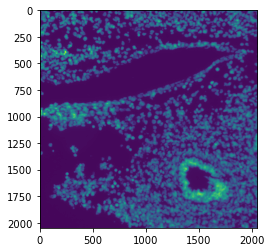

In [8]:
plt.imshow(img.xarray.values.squeeze())

## 2) PSF deconvolution

It is usually a good idea to perform some kind of deconvolution along the Z axis of the volume in order to remove the point spread function (PSF) generated by the microscope while acquiring the images. Thus, the PSF depends on the optical parameters of the microscope. In order to model it we will use the [PSFModels](https://github.com/tlambert03/PSFmodels) package.

To install it in the conda environment: <br>
<code> pip install psfmodels</code>

In [9]:
import psfmodels as psfm
from skimage import restoration
import numpy as np

This is a very computationally demanding step, that usually requires GPU support. That is why we will perform the operation on only a cropped part of one channel.


In [10]:
img = exp['fov_017'].get_image('primary').sel({Axes.CH: 3, Axes.ROUND: 1, Axes.ZPLANE: (0, None), Axes.X: (1200, 1712), Axes.Y: (1400, 1912)})
print(img.xarray.values.shape)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 168/168 [00:09<00:00, 16.87it/s]


(1, 1, 21, 512, 512)


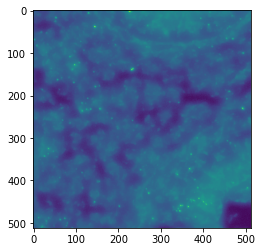

In [11]:
np_img = img.xarray.values.squeeze()
plt.imshow(np.log(2**16*np.max(np_img,axis=0)+1))


First we will create a the PSF based on the metadata extracted from the experiment. Finding all the data can be a little challenging depending on the format. 

In [12]:
xyz_res = [0.325, 0.325, 0.5] # micrometers per pixel

psf = psfm.make_psf(
    z=21,   # number of Z planes to calculate
    dxy=xyz_res[0], # pixel size in microns
    dz=xyz_res[2],     # axial size in microns
    nx=31,  # XY size of the output PSF
    pz=0,   # point source position above the coverslip
    ti0=610,    # working distance of the objective in microns
    ni0=1.0,    # design value of the immersion medium refractive index
    ni=1.0,     # experimental value of the immersion medium refractive index
    tg0=170.0,  # design value of the coverslip thickness in microns
    tg=170,     # experimental value of the coverslip thickness in microns
    ng0=1.0,    # design value of the coverslip refractive index
    ng=1.0,     # experimental value of the coverslip refractive index
    ns=1.0,     # sample refractive index
    wvl=.519,  # emission wavelength in microns
    NA=0.8,     # numercal aperture of the objective lense
    model='vectorial'  # PSF model to use
                    )

# psf.dtype
# psf[psf<1e-3*np.max(psf)] = 0
# # psf=psf/np.sum(psf)

Then we apply the Richardson Lucy deconvolution included **skimage**. There are several ways of optimizing this in order to allow for GPU support and speed up the process.But for this example, this function is simple enough.  

In [13]:
from scipy.ndimage import gaussian_filter

ss = 5
deconvolved_stack = np_img - gaussian_filter(np_img, sigma=(ss,ss,ss))
deconvolved_stack[deconvolved_stack<0]=0

deconvolved_RL = restoration.richardson_lucy(deconvolved_stack, 
                                            psf, iterations=10,
                                            clip=False)

Once the deconvolution is performed, we can compare the maximum intensity projected (MIP) images for two spots before and after. Hopefully, one can see how the PSF was removed and the dots look much crisper in after the deconvolution, allowing better detection.

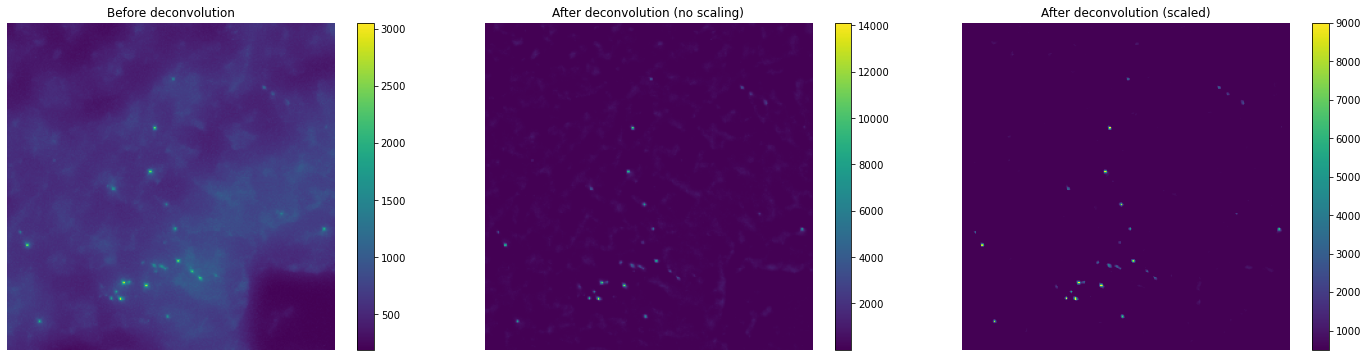

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
plt.imshow(2**16*np.max(np_img,axis=0)[256:,256:])
plt.title('Before deconvolution')
plt.axis('off')
plt.colorbar()
plt.subplot(1,3,2)
plt.imshow(2**16*np.max(deconvolved_RL,axis=0)[256:,256:])
plt.title('After deconvolution (no scaling)')
plt.axis('off')
plt.colorbar()
plt.subplot(1,3,3)
plt.imshow(2**16*np.max(deconvolved_RL,axis=0)[256:,256:], vmax=9000, vmin=500)
plt.title('After deconvolution (scaled)')
plt.axis('off')
plt.colorbar()
plt.tight_layout()

## 3) Register and stitch
It is usually the case that the rounds are slightly displaced. This hinders the decoding process, as the detecteds spots might not be aligned creating false positives or negatives. To solve this, some kind of registration is needed between rounds. Additionally, the FOV need to be stitched together, accounting for the overlap, to create the full image. 

It is a good idea to do both together to optimize the process. Depending on the complexity and the desired results, there are several tools for doing this. [Ashlar](https://github.com/labsyspharm/ashlar) is a widely used tool for this purpose. [Starfish](https://spacetx-starfish.readthedocs.io/en/latest/gallery/tutorials/plot_image_registration.html#sphx-glr-gallery-tutorials-plot-image-registration-py) also offers registration tools. <br>
Again registering and stitching the whole image is very computationally demanding, so we will show a manual registration process. 

Fisrt, we will use the starfish **diagnose_registration** tool to evaluate how bad is the displacement between rounds.

In [15]:
import matplotlib
from starfish.util.plot import diagnose_registration
from starfish.core.image._registration.transforms_list import TransformsList
from skimage import transform
from starfish.core.types import Axes, TransformType
from starfish.image import ApplyTransform

matplotlib.rcParams["figure.dpi"] = 150


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 61.93it/s]


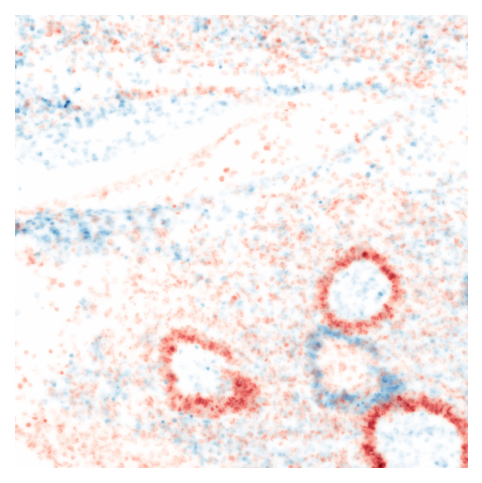

In [16]:
img = exp['fov_017'].get_image('nuclei').reduce({Axes.ZPLANE}, 'max')
diagnose_registration(img, {Axes.ROUND:0}, {Axes.ROUND:1})

It is obvious that the fact that the images are not aligned would greatly affect the decoding. Thus, it is necessary to find the translation that would make the channels align.

In [17]:
transforms_list = TransformsList([
    ({Axes.ROUND: 0}, TransformType.SIMILARITY, transform.SimilarityTransform(translation=(650,-35))),
    ({Axes.ROUND: 1}, TransformType.SIMILARITY, transform.SimilarityTransform())
                                ])
transforms_list

tile indices: {<Axes.ROUND: 'r'>: 0}
translation: y=650.0, x=-35.0, rotation: 0.0, scale: 1.0
tile indices: {<Axes.ROUND: 'r'>: 1}
translation: y=0.0, x=0.0, rotation: 0.0, scale: 1.0

In [18]:
warp = ApplyTransform.Warp()
registered_imgs = warp.run(img, transforms_list=transforms_list)

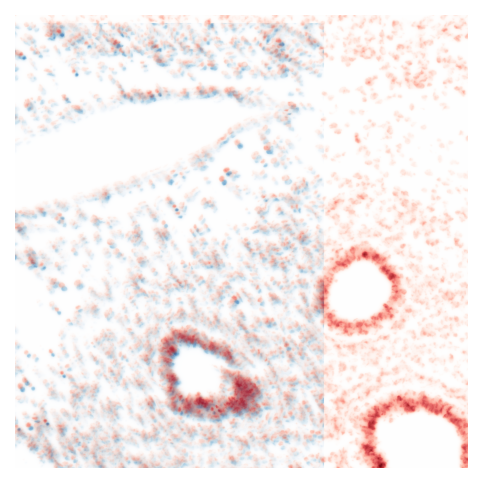

In [19]:
diagnose_registration(registered_imgs, {Axes.ROUND:0}, {Axes.ROUND:1})